- Apply rule-based extraction to identify machine learning methods in abstracts
- Test two complementary approaches:
  - **Regex-based matching** for known ML terms
  - **SciSpaCy + EntityRuler** for robust phrase detection

In [3]:
# Imports

from pathlib import Path
import json
import re
from typing import List
import ast

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
from collections import Counter


import spacy

In [4]:
# Paths

data_path = Path("../../data/short-raw-refs-abs")
processed_abstracts_path = Path("../../data/processed/abstracts")
save_path = processed_abstracts_path / "regex_scispacy"
ml_methods_path = Path("../../ml_methods/ml_methods_dict.json")
figure_path = Path("../../reports/figures/ml_methods")
table_path = Path("../../reports/tables/ml_methods")


# Ensure directories exist
for p in [data_path, processed_abstracts_path, save_path, figure_path, table_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")

All directories verified/created.


In [5]:
# Load abstracts dataset

abstracts_path = processed_abstracts_path / "abstracts.csv"
df = pd.read_csv(abstracts_path)

print(f"Loaded {len(df)} abstracts from {df['query_id'].nunique()} queries.")
df.head()

Loaded 52290 abstracts from 24 queries.


,query_id,eid,doi,title,abstract,clean_abs
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,"Indeed, highly efficient systems do not always..."
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",The detection and localization of quality-rela...
2,ml_anomaly_detection_production,2-s2.0-105016669957,10.1007/978-3-032-04200-2_5,Intelligent Defect Detection for Manufacturing...,"© The Author(s), under exclusive license to Sp...","In modern Industry, I4.0, artificial intellige..."
3,ml_anomaly_detection_production,2-s2.0-85218693791,10.1038/s41598-025-90810-w,Hybrid machine learning framework for predicti...,© The Author(s) 2025.The critical necessity fo...,The critical necessity for sophisticated predi...
4,ml_anomaly_detection_production,2-s2.0-105018301117,10.1016/j.comnet.2025.111753,BGP anomaly detection using the raw internet t...,© 2025 The AuthorsThe Border Gateway Protocol ...,"Hence, detecting any anomaly concerning BGP an..."


In [6]:
# Count how many rows each query_id has
query_counts = df["query_id"].value_counts().to_dict()

# Create a copy and map the counts to each row
df = df.copy()
df["query_size"] = df["query_id"].map(query_counts)

# Sort so that query groups with fewer rows are prioritized
df_sorted = df.sort_values(by="query_size", ascending=True)

# Remove duplicate DOIs, keeping the one in the smallest query group
df_dedup = df_sorted.drop_duplicates(subset="doi", keep="first").drop(columns=["query_size"])

# Print results
print("Original dataset size:", len(df))
print("After removing duplicates:", len(df_dedup))
print("Remaining duplicate DOIs:", df_dedup["doi"].duplicated().sum())

df = df_dedup

Original dataset size: 52290
After removing duplicates: 33130
Remaining duplicate DOIs: 0


In [7]:
with open(ml_methods_path, "r", encoding="utf-8") as f:
    ml_methods_dict = json.load(f)


## Regex matching

In [8]:
def extract_methods(text, term_dict):
    # Return empty list if input is not a string
    if not isinstance(text, str):
        return []
    
    found = []
    
    for method, phrases in term_dict.items():
        for phrase in phrases:
            # Escape special characters and enforce word boundaries
            pattern = r"\b" + re.escape(phrase.lower()) + r"\b"
            
            # Perform case-insensitive boundary-safe regex search
            if re.search(pattern, text.lower()):
                found.append(method)
                break  # Stop checking more variants for this method
    
    # Remove duplicates while preserving order
    return list(dict.fromkeys(found))

# Apply extraction with pandas progress bar
tqdm.pandas()
df["ml_methods_regex"] = df["clean_abs"].fillna("").progress_apply(
    lambda x: extract_methods(x, ml_methods_dict)
)


  0%|          | 0/33130 [00:00<?, ?it/s]

100%|██████████| 33130/33130 [01:29<00:00, 368.77it/s]


In [9]:
# Count how many ML methods were detected per abstract using the regex-based approach
df["method_count"] = df["ml_methods_regex"].str.len()
print(df["method_count"].value_counts().sort_index())

# Show the top 20 most frequently detected ML methods across all abstracts
print()
print(df.explode("ml_methods_regex")["ml_methods_regex"].value_counts().head())

# Save table of methods with counts 
method_counts = df.explode("ml_methods_regex")["ml_methods_regex"].value_counts().reset_index()
method_counts.columns = ["ml_method", "count"]
method_counts.to_csv(save_path / "ml_method_counts_regex.csv", index=False)

method_count
0     17479
1      7403
2      4072
3      2044
4      1096
5       521
6       284
7       127
8        62
9        23
10        9
11        4
12        4
13        2
Name: count, dtype: int64

ml_methods_regex
Neural Network                  6659
Random Forest                   3103
Support Vector Machine          2176
Decision Tree                   1652
Convolutional Neural Network    1365
Name: count, dtype: int64


In [12]:
# Save updated dataframe with extracted ML methods
output_path = save_path / "abstracts_with_ml_methods_regex.csv"
df.to_csv(output_path, index=False)

print(f"Saved processed abstracts with ML methods to: {output_path}")

Saved processed abstracts with ML methods to: ../../data/processed/abstracts/regex_scispacy/abstracts_with_ml_methods_regex.csv


In [21]:
# Ensure list column + count
df["ml_methods_regex"] = df["ml_methods_regex"].apply(lambda x: x if isinstance(x, list) else [])
df["method_count"] = df["ml_methods_regex"].apply(len)

# Method frequency table (top methods)
method_counts = (
    df.explode("ml_methods_regex")["ml_methods_regex"]
      .dropna()
      .value_counts()
)

method_counts.to_frame("count").to_csv(table_path / "method_counts.csv", index_label="method")

# Method-count distribution table
df["method_count"].value_counts().sort_index().to_frame("n_abstracts") \
  .to_csv(table_path / "method_count_distribution.csv", index_label="method_count")

print("Saved tables:", "method_counts.csv", "method_count_distribution.csv")


Saved tables: method_counts.csv method_count_distribution.csv


In [29]:
n_no_methods = (df["ml_methods_regex"].apply(len) == 0).sum()
share_no_methods = n_no_methods / len(df)

print(f"Abstracts with NO methods: {n_no_methods}")
print(f"Share with NO methods: {share_no_methods:.3f}")


Abstracts with NO methods: 17479
Share with NO methods: 0.528


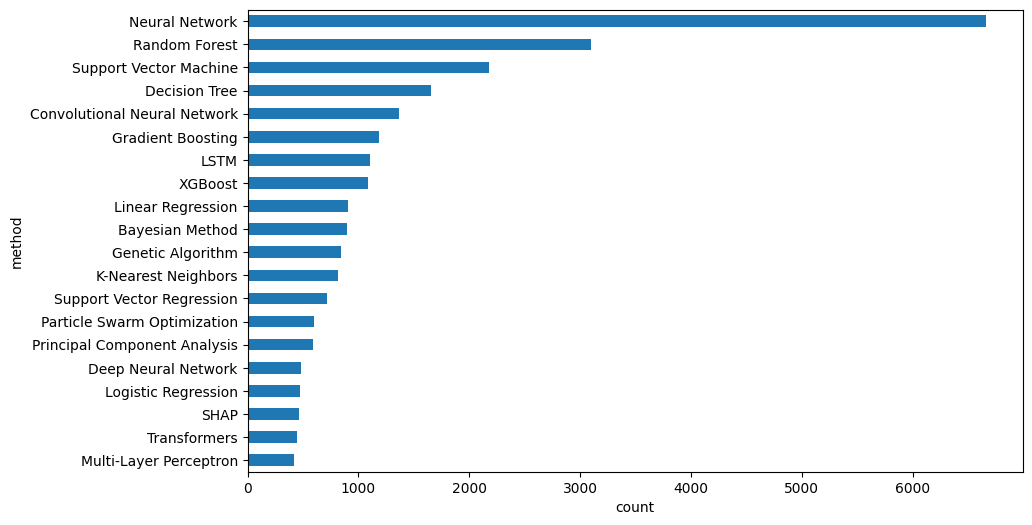

In [23]:
TOP_N = 20
top_methods = method_counts.head(TOP_N)

fig, ax = plt.subplots(figsize=(10, 6))
top_methods.sort_values().plot(kind="barh", ax=ax)

ax.set_xlabel("count")
ax.set_ylabel("method")

fig.savefig(figure_path / "top_methods_barh.png", dpi=300, bbox_inches="tight")
plt.show()


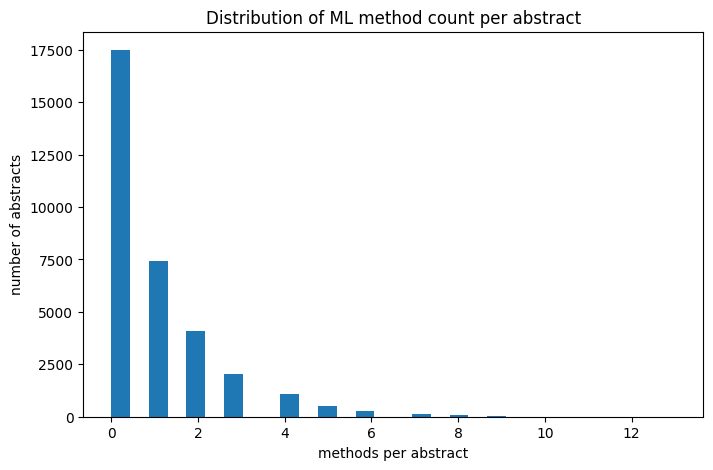

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))
df["method_count"].plot(kind="hist", bins=30, ax=ax)

ax.set_title("Distribution of ML method count per abstract")
ax.set_xlabel("methods per abstract")
ax.set_ylabel("number of abstracts")

fig.savefig(figure_path / "method_count_hist.png", dpi=300, bbox_inches="tight")
plt.show()


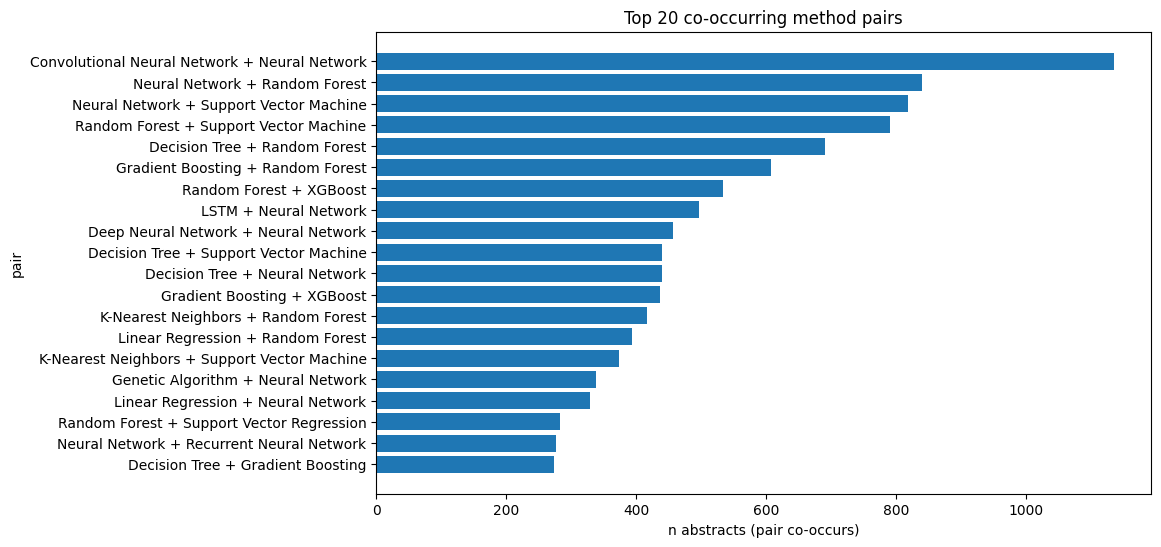

In [28]:
pair_counter = Counter()

for methods in df["ml_methods_regex"]:
    uniq = sorted(set(methods))
    for a, b in combinations(uniq, 2):
        pair_counter[(a, b)] += 1

pairs_df = (
    pd.DataFrame([(a, b, c) for (a, b), c in pair_counter.items()],
                 columns=["method_a", "method_b", "count"])
      .sort_values("count", ascending=False)
)

pairs_df.head(50).to_csv(table_path / "top_method_pairs.csv", index=False)

top_pairs = pairs_df.head(20).copy()
top_pairs["pair"] = top_pairs["method_a"] + " + " + top_pairs["method_b"]

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(top_pairs["pair"][::-1], top_pairs["count"][::-1])

ax.set_title("Top 20 co-occurring method pairs")
ax.set_xlabel("n abstracts (pair co-occurs)")
ax.set_ylabel("pair")

fig.savefig(figure_path / "top_method_pairs_barh.png", dpi=300, bbox_inches="tight")
plt.show()


## Scispacy

In [13]:
# Load the large SciSpaCy scientific language model and list all enabled NLP pipeline components
nlp = spacy.load("en_core_sci_lg")
print(nlp.pipe_names)

/cluster/home/mbergst/.venvs/ml-catalogue/lib/python3.11/site-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer', 'parser', 'ner']


In [14]:
# Add an EntityRuler to the NLP pipeline and register patterns for ML method detection
ruler = nlp.add_pipe("entity_ruler", before="ner")

patterns = []

# Create token-based matching patterns for each ML method phrase
for label, phrases in ml_methods_dict.items():
    for phrase in phrases:
        # Create a case-insensitive match pattern using LOWER tokens
        pattern = [{"LOWER": token.lower()} for token in phrase.split()]
        patterns.append({
            "label": "ML_METHOD",  # Custom entity label for ML methods
            "pattern": pattern,
            "id": label  # Canonical method name stored in ent_id_
        })

# Register all patterns in the EntityRuler
ruler.add_patterns(patterns)
print(f"Added {len(patterns)} ML_METHOD patterns to EntityRuler.")


Added 193 ML_METHOD patterns to EntityRuler.


In [15]:
# Extract ML method entities from a single abstract using the SciSpaCy EntityRuler
def extract_ml_methods_scispacy(text: str) -> List[str]:
    # Return empty list if input is not valid text
    if not isinstance(text, str) or not text.strip():
        return []
    
    doc = nlp(text)
    methods = []
    
    # Collect all detected ML_METHOD entities with their canonical IDs
    for ent in doc.ents:
        if ent.label_ == "ML_METHOD":
            canonical = ent.ent_id_ if ent.ent_id_ else ent.text
            methods.append(canonical)
    
    # Remove duplicates while preserving order
    unique_methods = list(dict.fromkeys(methods))
    return unique_methods


In [ ]:
# Apply the SciSpaCy EntityRuler to extract ML methods for all abstracts efficiently using nlp.pipe
texts = df["clean_abs"].fillna("").tolist()

ml_methods_all = []

# Process abstracts in batches
for doc in tqdm(nlp.pipe(texts, batch_size=32, n_process=8), total=len(texts)):
    methods = []
    
    # Collect ML_METHOD entities found in each processed document
    for ent in doc.ents:
        if ent.label_ == "ML_METHOD":
            canonical = ent.ent_id_ if ent.ent_id_ else ent.text
            methods.append(canonical)
            
    # Store unique detected methods for this abstract
    ml_methods_all.append(list(dict.fromkeys(methods)))

# Save results
df["ml_methods_scispacy"] = ml_methods_all


In [104]:
# Save updated dataframe with extracted ML methods
output_path = save_path / "abstracts_with_ml_methods.csv"
df.to_csv(output_path, index=False)

print(f"Saved processed abstracts with ML methods to: {output_path}")

Saved processed abstracts with ML methods to: ../../data/processed/abstracts/regex_scispacy/abstracts_with_ml_methods.csv


### SciSpacy: Analyze Abstracts with ML methods 

In [105]:
df = pd.read_csv(save_path / "abstracts_with_ml_methods.csv")

# Convert string lists to lists
df["ml_methods_scispacy"] = df["ml_methods_scispacy"].apply(ast.literal_eval)


In [122]:
# Display the first 10 papers with their extracted ML methods from SciSpaCy
df[["title", "doi", "ml_methods_scispacy"]].head()


,title,doi,ml_methods_scispacy
0,Blockchain-enabled decision system for reliabl...,10.1016/B978-0-443-33740-6.00012-8,[]
1,Systematic review of data modelling methods fo...,10.1080/19397038.2025.2563271,[]
2,Clustering Locations of Collection Centers in ...,10.1109/TEMSCON-ASPAC62480.2024.11025082,[]
3,"Artificial Intelligence: Basics, Impact, and H...",10.1188/23.CJON.595-601,[]
4,Intersections between materials science and ma...,10.1039/d3va00106g,[]


In [107]:
# Count how many ML methods SciSpaCy detected per abstract and summarize the distribution
df["method_count_scispacy"] = df["ml_methods_scispacy"].str.len()
df["method_count_scispacy"].value_counts().sort_index()


method_count_scispacy
0     17911
1      8015
2      3561
3      1782
4       951
5       468
6       236
7       110
8        56
9        22
10        9
11        5
12        2
13        2
Name: count, dtype: int64

In [108]:
# Show the top 20 most frequently detected ML methods using the SciSpaCy extraction
df.explode("ml_methods_scispacy")["ml_methods_scispacy"].value_counts().head(20)


ml_methods_scispacy
Neural Network                  5521
Random Forest                   3060
Support Vector Machine          2106
Decision Tree                   1614
Convolutional Neural Network    1195
Gradient Boosting               1173
XGBoost                         1053
LSTM                             964
Bayesian Method                  882
Linear Regression                862
K-Nearest Neighbors              798
Genetic Algorithm                748
Support Vector Regression        693
Principal Component Analysis     562
Particle Swarm Optimization      542
Logistic Regression              469
Deep Neural Network              458
SHAP                             445
Multi-Layer Perceptron           391
Gaussian Process Regression      385
Name: count, dtype: int64

In [109]:
# Randomly inspect 5 abstracts where SciSpaCy successfully detected ML methods
df[df["method_count_scispacy"] > 0][["title", "doi", "ml_methods_scispacy", "ml_methods_regex"]].sample(5)


,title,doi,ml_methods_scispacy,ml_methods_regex
20817,Establishment and Optimization of Gas Flow Pre...,10.23919/ChiCC.2018.8483446,"[Support Vector Machine, Genetic Algorithm]","['Support Vector Machine', 'Genetic Algorithm']"
19577,Towards Predictive Maintenance of a Heavy-Duty...,10.36001/phmconf.2022.v14i1.3148,"[Neural Network, Bayesian Method]","['Bayesian Method', 'Neural Network']"
21946,Deep Learning-Based Hardware Trojan Detection ...,10.1109/TETC.2021.3116484,"[LSTM, Convolutional Neural Network]","['Neural Network', 'Convolutional Neural Netwo..."
26209,LOF weighted KNN regression ensemble and its a...,10.1007/s12046-023-02283-0,"[K-Nearest Neighbors, Local Outlier Factor]","['K-Nearest Neighbors', 'Local Outlier Factor']"
705,Leveraging AutoML to optimize dataset selectio...,10.1016/j.csbj.2025.10.052,[SHAP],['SHAP']


## Analyze - with both Regex and SciSpacy

In [125]:
# How many abstracts had minimum 1 method, and how many had none, for each method extraction approach?
regex_with_methods = (df["method_count"] > 0).sum()
regex_without_methods = (df["method_count"] == 0).sum()
scispacy_with_methods = (df["method_count_scispacy"] > 0).sum()
scispacy_without_methods = (df["method_count_scispacy"] == 0).sum()

print("Summary of abstracts with/without detected ML methods:")

print("Regex - With methods:", regex_with_methods)
print("Regex - Without methods:", regex_without_methods)
print("SciSpaCy - With methods:", scispacy_with_methods)
print("SciSpaCy - Without methods:", scispacy_without_methods)

Summary of abstracts with/without detected ML methods:
Regex - With methods: 15651
Regex - Without methods: 17479
SciSpaCy - With methods: 15219
SciSpaCy - Without methods: 17911


In [110]:
# Convert stringified lists in ml_methods_regex to real Python lists
df["ml_methods_regex"] = df["ml_methods_regex"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

In [111]:
# Find all ML methods from the dictionary that are never detected by either regex or SciSpaCy

# Ensure we are working with sets for easier membership checks
df["regex_set"] = df["ml_methods_regex"].apply(lambda x: set(x) if isinstance(x, list) else set())
df["scispacy_set"] = df["ml_methods_scispacy"].apply(lambda x: set(x) if isinstance(x, list) else set())

all_methods = list(ml_methods_dict.keys())
zero_hit_methods = []

for method in all_methods:
    regex_hits = df["regex_set"].apply(lambda s: method in s).sum()
    scispacy_hits = df["scispacy_set"].apply(lambda s: method in s).sum()
    
    if regex_hits == 0 and scispacy_hits == 0:
        zero_hit_methods.append(method)

print(f"Methods with 0 matches in both regex and SciSpaCy: {len(zero_hit_methods)}")
zero_hit_methods


Methods with 0 matches in both regex and SciSpaCy: 1


['Invariant Causal Prediction']

In [120]:
# Ensure we are working with list -> set for easier membership checks
df["regex_set"] = df["ml_methods_regex"].apply(lambda x: set(x) if isinstance(x, list) else set())
df["scispacy_set"] = df["ml_methods_scispacy"].apply(lambda x: set(x) if isinstance(x, list) else set())

# Collect the universe of methods seen by either approach
all_methods = sorted(
    set().union(*df["regex_set"]).union(*df["scispacy_set"])
)

rows = []

# For each method, compute overlap stats between regex and SciSpaCy
for method in all_methods:
    regex_mask = df["regex_set"].apply(lambda s: method in s)
    scis_mask = df["scispacy_set"].apply(lambda s: method in s)
    
    regex_count = regex_mask.sum()
    scispacy_count = scis_mask.sum()
    both_count = (regex_mask & scis_mask).sum()
    regex_only = (regex_mask & ~scis_mask).sum()
    scispacy_only = (~regex_mask & scis_mask).sum()
    union_count = (regex_mask | scis_mask).sum()
    
    jaccard = both_count / union_count if union_count > 0 else 0.0
    
    rows.append({
        "method": method,
        "regex_count": regex_count,
        "scispacy_count": scispacy_count,
        "both_count": both_count,
        "regex_only": regex_only,
        "scispacy_only": scispacy_only,
        "union_count": union_count,
        "jaccard_overlap": jaccard,
    })

overlap_df = pd.DataFrame(rows)

# Sort by popularity (or by overlap) as you like
overlap_df_sorted = overlap_df.sort_values("union_count", ascending=False)

# For a quick view of the overlap statistics
overlap_df_sorted.head()

,method,regex_count,scispacy_count,both_count,regex_only,scispacy_only,union_count,jaccard_overlap
66,Neural Network,6659,5521,5521,1138,0,6659,0.829103
79,Random Forest,3103,3060,3060,43,0,3103,0.986142
91,Support Vector Machine,2176,2106,2106,70,0,2176,0.967831
15,Decision Tree,1652,1614,1614,38,0,1652,0.976998
13,Convolutional Neural Network,1365,1195,1195,170,0,1365,0.875458


In [113]:
# Extract rows where SciSpaCy found at least one method
# and regex found none
scispacy_only_df = df[
    (df["scispacy_set"].apply(len) > 0) &
    (df["regex_set"].apply(len) == 0)
]

scispacy_only_df.head()

,query_id,eid,doi,title,abstract,clean_abs,ml_methods_regex,method_count,ml_methods_scispacy,method_count_scispacy,regex_set,scispacy_set
13735,ml_process_control,2-s2.0-85020415893,10.1117/12.2258039,Computational overlay metrology with adaptive ...,© 2017 SPIE.With photolithography as the funda...,With photolithography as the fundamental patte...,[],0,[Gradient Boosting],1,{},{Gradient Boosting}


In [119]:
# Extract rows where Regex found at least one method
# and SciSpacy found none
regex_only_df = df[
    (df["regex_set"].apply(len) > 0) &
    (df["scispacy_set"].apply(len) == 0)
]

# How many rows are in this set?
print("Number of abstracts where only Regex found methods:", len(regex_only_df))

regex_only_df.head(5)

Number of abstracts where only Regex found methods: 433


,query_id,eid,doi,title,abstract,clean_abs,ml_methods_regex,method_count,ml_methods_scispacy,method_count_scispacy,regex_set,scispacy_set
126,ml_recycling_manufacturing,2-s2.0-85166934684,10.1080/15376494.2023.2238220,Machine learning and RSM-CCD analysis of green...,"© 2023 Taylor & Francis Group, LLC.This study ...",This study aims to serve as a performance indi...,[Neural Network],1,[],0,{Neural Network},{}
156,ml_remanufacturing,2-s2.0-85185884385,10.1115/1.4064257,Multiscale Feature Fusion Convolutional Neural...,© 2024 by ASME.The detection of surface damage...,The detection of surface damage is an importan...,[Convolutional Neural Network],1,[],0,{Convolutional Neural Network},{}
253,ml_plm,2-s2.0-105000236624,10.1016/j.cie.2025.111034,Early screening of potential breakthrough tech...,© 2025 Elsevier LtdMachine learning (ML) appro...,"However, their practicality is often limited b...",[Attention Mechanism],1,[],0,{Attention Mechanism},{}
289,ml_plm,2-s2.0-85138449494,10.1109/TPAMI.2021.3095381,ProtTrans: Toward Understanding the Language o...,© 1979-2012 IEEE.Computational biology and bio...,Computational biology and bioinformatics provi...,[Transformers],1,[],0,{Transformers},{}
372,ml_plm,2-s2.0-85209659742,10.1007/s11277-024-11659-2,Automated Sleep Disorder Diagnosis Utilising E...,"© The Author(s), under exclusive licence to Sp...",Automated sleep disorders diagnosis is difficu...,[LSTM],1,[],0,{LSTM},{}


## Extract ML-Methods

In [115]:
# # Define common "method head" words and extract ML-related candidate phrases from parsed abstracts
# METHOD_HEADS = {
#     "network", "networks",
#     "model", "models",
#     "algorithm", "algorithms",
#     "classifier", "classifiers",
#     "regression",
#     "forest", "forests",
#     "clustering", "clusterer", "clusterers",
#     "encoder", "encoders",
#     "autoencoder", "autoencoders",
#     "transformer", "transformers",
#     "estimators", "estimator",
#     "approach", "approaches",
#     "architecture", "architectures",
# }

# def extract_candidate_phrases_from_doc(doc):
#     """Extract candidate ML-method phrases from a spaCy Doc."""
#     candidates = []

#     # Noun chunks that end with a "method head" word
#     for chunk in doc.noun_chunks:
#         tokens = [t for t in chunk if not t.is_punct]
#         if not tokens:
#             continue

#         head = tokens[-1].lemma_.lower()
#         if head in METHOD_HEADS:
#             if 1 <= len(tokens) <= 7:
#                 phrase = chunk.text.strip()
#                 candidates.append(phrase)

#     # All-caps acronyms (e.g., SVM, CNN, LSTM)
#     for token in doc:
#         if (
#             token.is_alpha
#             and token.text.isupper()
#             and 2 <= len(token.text) <= 6
#         ):
#             candidates.append(token.text)

#     # Remove duplicates, preserve order
#     return list(dict.fromkeys(candidates))


In [116]:
# # Extract ML-related candidate phrases from all abstracts efficiently using spaCy's nlp.pipe
# texts = df["clean_abs"].fillna("").tolist()

# candidate_counter = collections.Counter()

# # Batch processing with multiple processes for faster NLP execution
# for doc in tqdm(
#     nlp.pipe(texts, batch_size=64, n_process=8),
#     total=len(texts)
# ):
#     for cand in extract_candidate_phrases_from_doc(doc):
#         candidate_counter[cand] += 1

# print(f"Extracted {len(candidate_counter)} unique candidate phrases.")


In [117]:
# # Show the top candidate phrases by frequency
# for phrase, count in candidate_counter.most_common(100):
#     print(f"{count:4d}  {phrase}")
